# Letters
The main goal of this exercise is to train a diffusion model to generate letters images.

We will use the az-handwritten-alphabets-in-csv-format dataset by sachinpatel21 on Kaggle

In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
import kagglehub
from pandas import read_csv, concat
from pandas import DataFrame

from PIL import Image
import numpy as np

## Data
Download, transform and import images from dataset to program

In [2]:
# Import the Dataset from kaggle and load on a Tensor
Nist_dataset = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

chunksize = 250

# the list that contains all the dataframes
list_of_dataframes = []

for df in read_csv(Nist_dataset+"/A_Z Handwritten Data.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df)

# if you want all the dataframes together, here it is
handwritten_alphabet = concat(list_of_dataframes)


In [3]:

class HandwrittenAlphabetDataset(torch.utils.data.Dataset):
    def __init__(self, Alphabet_dataframe:DataFrame, img_size: int, transform=None):
        """
        Args:
            csv_file (string): Ruta al archivo CSV.
            transform (callable, optional): Transformación opcional para aplicar a la imagen.
        """
        self.data = Alphabet_dataframe
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtener la etiqueta y los píxeles
        label = self.data.iloc[idx, 0]
        pixels = self.data.iloc[idx, 1:].values.astype(np.uint8)

        # Reformar los píxeles en una imagen (ej. 28x28)
        img = pixels.reshape(self.img_size, self.img_size)
        img = Image.fromarray(img) # Convertir a objeto PIL Image

        if self.transform:
            img = self.transform(img)

        return img, label

In [22]:
image_size = 32

#Prepare images to load to the net

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),              #Convert to Tensor
        transforms.Normalize([0.5],[0.5])   #Map tp -1 to 1
    ]
)

def transform(examples):
    examples = preprocess(examples)
    return examples


In [23]:
# Create and Split the dataset on Train, Validation and Test Datasets
dataset = HandwrittenAlphabetDataset(handwritten_alphabet, 28, transform)

train,val,test = torch.utils.data.random_split(dataset,[0.8,0.1,0.1])


### A little fnct to show easily images

In [7]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

## Preparing images to the net

In [24]:
#   Create the Dataloader
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True
)


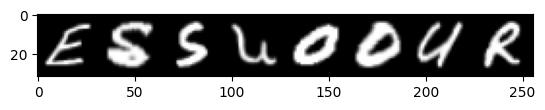

In [25]:
show_images(next(iter(train_dataloader))[0][:8])

## Add Noise

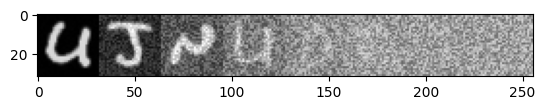

In [26]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_dataloader))
x = batch[0][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

## U-Net

In [28]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])
